In [8]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import numpy as np
import torch
reorder_idx = [0, 13, 14, 15, 20, 1, 2, 3, 16, 4, 5, 6, 17, 10, 11, 12, 19, 7, 8, 9, 18]
def get_joints_3d(joints):
    # * Transfer from UNITY coordinate system
    joints[:, 1:] = -joints[:, 1:]
    joints = joints[reorder_idx]
    joints = joints - joints[9] + np.array([0, 0, 0.5])  # * We use ortho projection, so we need to shift the center of the hand to the origin
    return joints

In [4]:

from scipy.linalg import orthogonal_procrustes
def align_w_scale(mtx1, mtx2):
    """ Align the predicted entity in some optimality sense with the ground truth. """
    # center
    t1 = mtx1.mean(0)
    t2 = mtx2.mean(0)
    mtx1_t = mtx1 - t1
    mtx2_t = mtx2 - t2

    # scale
    s1 = np.linalg.norm(mtx1_t) + 1e-8
    mtx1_t /= s1
    s2 = np.linalg.norm(mtx2_t) + 1e-8
    mtx2_t /= s2

    # orth alignment
    R, s = orthogonal_procrustes(mtx1_t, mtx2_t)

    # apply trafos to the second matrix
    # mtx2_t = np.dot(mtx2_t, R.T) * s
    # mtx2_t = mtx2_t * s1 + t1
    s3 = np.linalg.norm(mtx2) + 1e-8
    mtx2_t = np.dot(mtx2, R.T) / s3

    return mtx2_t

In [5]:
standard_j =  [[1.8155813217163086, 0.15561437606811523, 1.1083018779754639], [2.406423807144165, 0.5383367538452148, 1.304732084274292], [2.731782913208008, 1.172149658203125, 1.335669994354248], [2.681248903274536, 1.7862586975097656, 1.2639415264129639], [2.3304858207702637, 2.234518527984619, 1.1211540699005127], [2.341385841369629, 1.37321138381958, 2.0816190242767334], [2.3071250915527344, 2.0882482528686523, 1.7858655452728271], [2.2974867820739746, 2.293468952178955, 1.3347842693328857], [2.31135630607605, 1.9055771827697754, 1.029522180557251], [1.851935863494873, 1.30698823928833, 2.1360342502593994], [1.8758153915405273, 2.124051094055176, 2.5652201175689697], [1.973258376121521, 2.431856632232666, 2.1032679080963135], [2.0731117725372314, 2.644174098968506, 1.616095781326294], [1.471063256263733, 1.2448792457580566, 2.0854008197784424], [1.4334478378295898, 1.9523506164550781, 1.5718071460723877], [1.6441740989685059, 1.7141218185424805, 1.1860997676849365], [1.760351300239563, 1.242896556854248, 1.305544137954712], [1.1308115720748901, 1.1045317649841309, 1.9674842357635498], [1.0435627698898315, 1.6727776527404785, 1.8200523853302002], [1.2601540088653564, 1.6069226264953613, 1.4762027263641357], [1.4999980926513672, 1.5507283210754395, 1.1099226474761963]]
standard_j = np.array(standard_j)

In [6]:
import os 
import pickle5 as pickle

joint_3d = list()
for idx in range(15):
    data_record = pickle.load(open('datasets/DARTset/train/part_%i.pkl' % idx, "rb"))
    for k in range(len(data_record["pose"])):
        joint_3d.append(data_record['joint3d'][k].astype(np.float32))
joint_3d = np.array(joint_3d)
dart_set = np.empty(joint_3d.shape)
for idx, joint in enumerate(joint_3d):
    dart_set[idx] = align_w_scale(standard_j, joint)
dart_set = dart_set - dart_set[:, 0][:, None, :].repeat(21, axis =1)
dart_set = dart_set.reshape(-1, 63)
        


KeyboardInterrupt: 

In [ ]:
import json
with open('datasets/general_512/annotations/train/CISLAB_train_joint_3d.json', 'r') as f:
    our_pose = json.load(f)
our_pose = [our_pose['0'][i]['world_coord'][:21] for i in our_pose['0'].keys()]
our_pose_data = np.array(our_pose)
our_set = np.empty(our_pose_data.shape)
for idx, joint in enumerate(our_pose_data):
    our_set[idx] = align_w_scale(standard_j, joint)
our_set = our_set - our_set[:, 0][:, None, :].repeat(21, axis =1)
our_set = our_set.reshape(-1, 63)

In [12]:

# with open('datasets/general_512/annotations/train/CISLAB_train_data_update.pkl', 'rb') as f:
#     our_pose = pickle.load(f)
# our_pose = [our_pose[i]['joint_3d'] for i in our_pose.keys()]
# our_set = np.array(our_pose)
# # our_set = np.empty(our_pose_data.shape)
# # for idx, joint in enumerate(our_pose_data):
# #     our_set[idx] = align_w_scale(standard_j, joint)
# # our_set = our_set - our_set[:, 0][:, None, :].repeat(21, axis =1)
# our_set = our_set.reshape(-1, 63)
# our_set.shape

In [ ]:
import json
with open('datasets/frei_test/evaluation_xyz.json') as f:
    frei_joint = json.load(f)
frei_joint = np.array(frei_joint)
frei_set = np.empty(frei_joint.shape)
for idx, joint in enumerate(frei_joint):
    frei_set[idx] = align_w_scale(standard_j, joint)
frei_set = frei_set - frei_set[:, 0][:, None, :].repeat(21, axis =1)
frei_set = frei_set.reshape(-1, 63)

In [1]:

def crop(img, center, scale, res, rot=0):
    # """Crop image according to the supplied bounding box."""
    # Upper left point
    ul = np.array(transform([1, 1], center, scale, res, invert=1))-1
    # Bottom right point
    br = np.array(transform([res[0]+1, 
                             res[1]+1], center, scale, res, invert=1))-1
    # Padding so that when rotated proper amount of context is included
    pad = int(np.linalg.norm(br - ul) / 2 - float(br[1] - ul[1]) / 2)
    if not rot == 0:
        ul -= pad
        br += pad
    new_shape = [br[1] - ul[1], br[0] - ul[0]]
    if len(img.shape) > 2:
        new_shape += [img.shape[2]]
    new_img = np.zeros(new_shape, dtype = np.uint8)

    # Range to fill new array
    new_x = max(0, -ul[0]), min(br[0], len(img[0])) - ul[0]
    new_y = max(0, -ul[1]), min(br[1], len(img)) - ul[1]
    # Range to sample from original image
    old_x = max(0, ul[0]), min(len(img[0]), br[0])
    old_y = max(0, ul[1]), min(len(img), br[1])

    new_img[new_y[0]:new_y[1], new_x[0]:new_x[1]] = img[old_y[0]:old_y[1], 
                                                        old_x[0]:old_x[1]]
    
    if not rot == 0:
        # Remove padding
        # new_img = scipy.ndimage.interpolation.rotate(new_img, rot)
        new_img = myimrotate(new_img, rot)
        new_img = new_img[pad:-pad, pad:-pad]

    # new_img = scipy.misc.imresize(new_img, res)
    new_img = myimresize(new_img, [res[0], res[1]])
    return new_img


    
def get_transform(center, scale, res, rot=0):
    """Generate transformation matrix."""
    h = res[0] * scale
    # h = 200 * scale
    t = np.zeros((3, 3))
    t[0, 0] = float(res[1]) / h
    t[1, 1] = float(res[0]) / h
    t[0, 2] = res[1] * (-float(center[0]) / h + .5)
    t[1, 2] = res[0] * (-float(center[1]) / h + .5)
    t[2, 2] = 1
    if not rot == 0:
        rot = -rot # To match direction of rotation from cropping
        rot_mat = np.zeros((3,3))
        rot_rad = rot * np.pi / 180
        sn,cs = np.sin(rot_rad), np.cos(rot_rad)
        rot_mat[0,:2] = [cs, -sn]
        rot_mat[1,:2] = [sn, cs]
        rot_mat[2,2] = 1
        # Need to rotate around center
        t_mat = np.eye(3)
        t_mat[0,2] = -res[1]/2
        t_mat[1,2] = -res[0]/2
        t_inv = t_mat.copy()
        t_inv[:2,2] *= -1
        t = np.dot(t_inv,np.dot(rot_mat,np.dot(t_mat,t)))
    return t
def transform(pt, center, scale, res, invert=0, rot=0):
    """Transform pixel location to different reference."""
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        # t = np.linalg.inv(t)
        t_torch = torch.from_numpy(t)
        t_torch = torch.inverse(t_torch)
        t = t_torch.numpy()
    new_pt = np.array([pt[0]-1, pt[1]-1, 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int)+1


In [2]:
import cv2
def myimrotate(img, angle, center=None, scale=1.0, border_value=0, auto_bound=False):
    if center is not None and auto_bound:
        raise ValueError('`auto_bound` conflicts with `center`')
    h, w = img.shape[:2]
    if center is None:
        center = ((w - 1) * 0.5, (h - 1) * 0.5)
    assert isinstance(center, tuple)

    matrix = cv2.getRotationMatrix2D(center, angle, scale)
    if auto_bound:
        cos = np.abs(matrix[0, 0])
        sin = np.abs(matrix[0, 1])
        new_w = h * sin + w * cos
        new_h = h * cos + w * sin
        matrix[0, 2] += (new_w - w) * 0.5
        matrix[1, 2] += (new_h - h) * 0.5
        w = int(np.round(new_w))
        h = int(np.round(new_h))
    rotated = cv2.warpAffine(img, matrix, (w, h), borderValue=border_value)
    return rotated

def myimresize(img, size, return_scale=False):

    h, w = img.shape[:2]
    resized_img = cv2.resize(
        img, (size[0],size[1]))
    if not return_scale:
        return resized_img
    else:
        w_scale = size[0] / w
        h_scale = size[1] / h
        return resized_img, w_scale, h_scale

In [3]:
def j2d_processing(kp, scale, r, raw_res):
    """Process gt 2D keypoints and apply all augmentation transforms."""
    nparts = kp.shape[0]
    for i in range(nparts):
        kp[i, 0:2] = transform(kp[i, 0:2]+1, (raw_res/2, raw_res/2), scale,
                                [raw_res, raw_res], rot=r)
    return kp

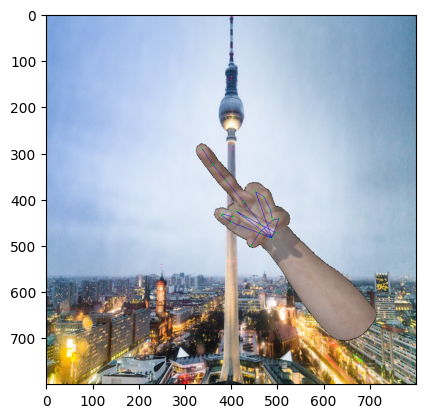

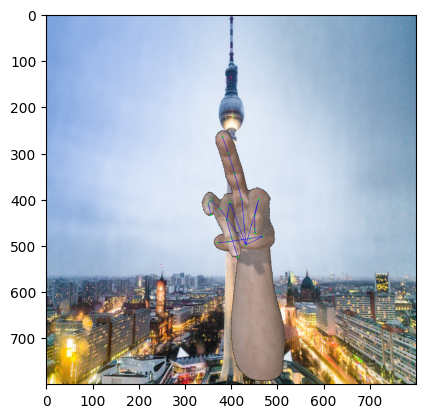

In [10]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pickle

with open('datasets/data_230710/annotations/train/sample.pkl', 'rb') as f:
    meta = pickle.load(f)
    
for idx in range(2):
    r = min(
        2 * 1,
        max(-2 * 1, np.random.randn() * 1),
    )
    scale = min(
        1.1,
        max(
            1 - 0.3, np.random.randn() * 0.3 + 1
        ))
    bbox = np.array(meta[idx]['bbox']).reshape(2, 2)
    joint_2d = np.array(meta[idx]['joint_2d'])

    center = (int((bbox[0][0] + bbox[1][0])/2) , int((bbox[0][1] + bbox[1][1])/2))
    joint_2d = joint_2d - center + (400, 400)
    n_joint_2d = j2d_processing(joint_2d, 1, 50, 800)
    
    
    ori_img = cv2.imread(os.path.join('datasets/data_230710/images/train', '/'.join(meta[idx]['file_name'].split('/')[1:])))
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    cropped_img = crop(ori_img, center, 1, [800, 800], rot=50).astype(np.uint8)
    bg_img= cv2.imread('datasets/data_230710/background/city_5.jpg')
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
    bg_img = cv2.resize(bg_img, (cropped_img.shape[1], cropped_img.shape[0]))
    
    index = np.where((cropped_img[:, :, 0] == 0) & (cropped_img[:, :, 1] == 0) & (cropped_img[:, :, 2] == 0))
    cropped_img[index] = bg_img[index]
    
    cropped_img = visualize(cropped_img, n_joint_2d)

    # index2 = np.where((ori_img[:, :, 0] == 0) & (ori_img[:, :, 1] == 0) & (ori_img[:, :, 2] == 0))
    # ori_img[index2] = bg_img[index2]

    # cropped_img2 = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
    plt.imshow(cropped_img)
    plt.show()
    


In [5]:
def visualize(images, joint_2d):
    image = images.copy()
    parents = np.array([-1, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19])
    for i in range(21):
        cv2.circle(image, (int(joint_2d[i][0]), int(joint_2d[i][1])), 2, [0, 255, 0],
                    thickness=-1)
        if i != 0:
            cv2.line(image, (int(joint_2d[i][0]), int(joint_2d[i][1])),
                        (int(joint_2d[parents[i]][0]), int(joint_2d[parents[i]][1])),
                        [0, 0, 255], 1)
            
    return image

In [ ]:
import cv2
import pickle

img = cv2.imread("../obman_train/datasymlinks/obman/val/rgb_hand/00009268.jpg")
meta = pickle.load(open("../obman_train/datasymlinks/obman/val/meta/00009268.pkl", "rb"))